In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from astropy import constants as csts

In [139]:
class System:
    def __init__(self, num_objects: int, x: np.ndarray, v: np.ndarray, m: np.ndarray, G: float, softening: float) -> None:
        self.num_objects = num_objects
        self.x = x
        self.v = v
        self.m = m
        self.G = G
        self.softening = softening # to avoid dividing by zero
        
    def compute_forces(self) -> np.ndarray:
        forces = np.zeros_like(self.x)
        for i in range(self.num_objects):
            for j in range(self.num_objects):
                if i != j:
                    r_ij = self.x[j] - self.x[i]
                    dist = np.linalg.norm(r_ij) + self.softening
                    force_ij = self.G * self.m[i] * self.m[j] * (r_ij/(dist**3))
                    forces[i] += force_ij
        return forces
    
    # First test - Euler Method: Simplest way to approximate solution.    
    def update_params_euler(self, dt:float) -> None:
        forces = self.compute_forces()
        accs = forces/self.m[:,np.newaxis]
        # changing shape of mass array such that shapes compute for division
        
        # Updating velocity and position
        self.v += accs * dt
        self.x += self.v * dt
        
    def simulation(self, n_steps: int, dt: float) -> list:
        trajectory = [self.x.copy()]
        
        for i in range(n_steps):
            self.update_params_euler(dt)
            # this computes forces and updates parameters
            trajectory.append(self.x.copy())
        return trajectory

In [140]:
# # 2 body check:
# G = 1
# num_objects = 2

# initial_positions = np.array([[1, 0, 0], [-1, 0, 0]], dtype=float)
# masses = np.array([1.0, 1.0])
# v_circ = np.sqrt(G * masses[1] / 2.0)
# initial_velocities = np.array([[0, -v_circ, 0], [0, v_circ, 0]])

# system = System(num_objects = num_objects, x=initial_positions, v=initial_velocities, m=masses, G=G, softening=1e-5)
# trajectory = system.simulation(n_steps =1000, dt=0.01)
# trajectory = np.array(trajectory)

# for i in range(num_objects):
#     plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], label=f'Body {i+1}')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Trajectories of N Bodies')
# plt.axis('equal')
# plt.legend()
# plt.show()

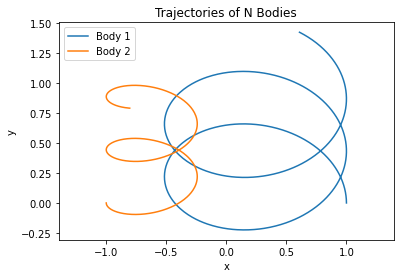

In [155]:
# 2 body
%matplotlib inline
G = 1 # since we are using masses, positions of order 1, use natural units
num_objects = 2
initial_positions = np.array([[1, 0, 0], [-1, 0, 0]], dtype=float)
initial_velocities = np.array([[0, 0.5, 0], [0, -0.1, 0]], dtype=float)
masses = np.array([1.0, 2.0])

system = System(num_objects = num_objects, x=initial_positions, v=initial_velocities, m=masses, G=G, softening=1e-5)
trajectory = system.simulation(n_steps =1000, dt=0.01)
trajectory = np.array(trajectory)

for i in range(num_objects):
    plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], label=f'Body {i+1}')
    # trajectory is array with [time steps, index of body, spatial dimension]
    # so plotting all time steps for given body in x, then y
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of N Bodies')
plt.axis('equal')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


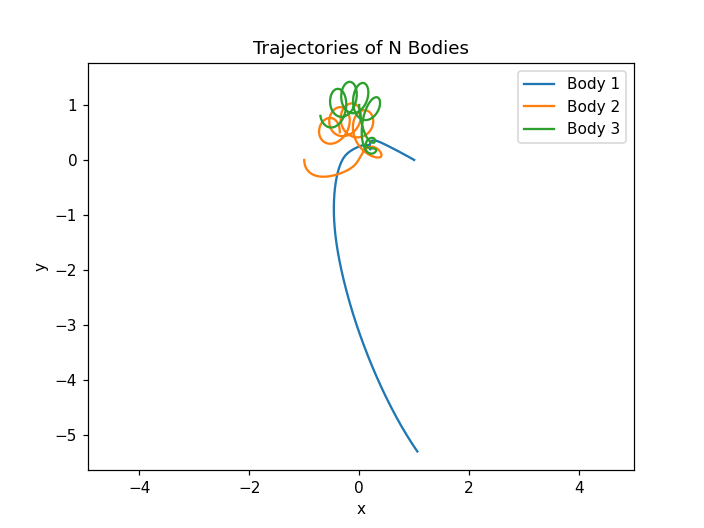

In [135]:
# 3 body

G = 1 # since we are using masses, positions of order 1, use natural units
num_objects = 3
initial_positions = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0]], dtype=float)
initial_velocities = np.array([[0, 0, 0], [0, -0.5, 0], [0, 0, 0]], dtype=float)
masses = np.array([1.0, 1.0, 1.0])

system = System(num_objects = num_objects, x=initial_positions, v=initial_velocities, m=masses, G=G, softening=1e-5)
trajectory = system.simulation(n_steps =1000, dt=0.01)
trajectory = np.array(trajectory)

for i in range(num_objects):
    plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], label=f'Body {i+1}')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of N Bodies')
plt.axis('equal')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


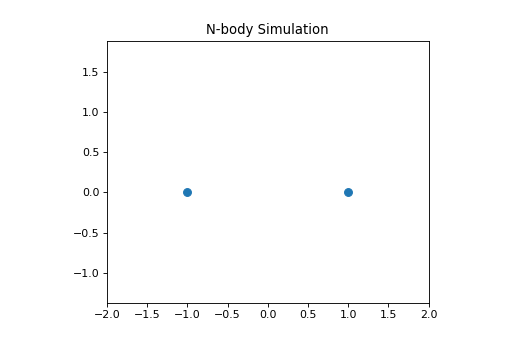

In [148]:
%matplotlib notebook
# Assume `trajectory` is already computed and is shape (n_steps, N, 3)
n_steps, N, _ = trajectory.shape

# Set up the figure and axes
fig, ax = plt.subplots()
ax.set_xlim(np.min(trajectory[:,:,0]) - 1, np.max(trajectory[:,:,0]) + 1)
ax.set_ylim(np.min(trajectory[:,:,1]) - 1, np.max(trajectory[:,:,1]) + 1)
ax.set_aspect('equal')
ax.set_title('N-body Simulation')

# Initialize scatter plot
scat = ax.scatter([], [], s=50)

# Optional: add trails
trails = [ax.plot([], [], lw=1)[0] for _ in range(N)]

# Update function
def update(frame):
    x = trajectory[frame, :, 0]
    y = trajectory[frame, :, 1]
    scat.set_offsets(np.column_stack((x, y)))
    
    # Update trails
    for i in range(N):
        trails[i].set_data(trajectory[:frame+1, i, 0], trajectory[:frame+1, i, 1])
    return scat, *trails

# Create animation
ani = FuncAnimation(fig, update, frames=n_steps, interval=10, blit=True)

plt.show()

In [ ]:
# For later 
# def CoM_correction(self) -> None:
#         #Setting CoM of position and velocity to zero to prevent net motion of system during simulation.
#         x_com = np.zeros(3)
#         v_com = np.zeros(3)
#         M = 0.0
#         for i in range(self.num_objects):
#             x_com += self.m[i]*self.x[i]
#             v_com += self.m[i]*self.v[i]
#             M += self.m[i]
        
#         x_com /= M
#         v_com /= M
#         self.x -= x_com
#         self.v -= v_com
        
    

**Scalar Form**:

Newton's Law of Gravitation gives the *magnitude* of the force between two point masses:

$ F = G \frac{m_{1}m_{2}}{r^{2}} $

but does not consider direction. We need this for simulation.

**Vector Form**:
Must consider direction from one vector to another.

Let:


- $ \vec{r_{i}} $ be position of object $i$

-  $ \vec{r_{ij}} $ is vector pointing from $i$ to $j$

- Its magnitude is $r =$ |$\vec{r_{ij}}$|

The unit vector in that direction is: 

$ \hat{r}_{ij} = \frac{\vec{r_{ij}}}{|\vec{r_{ij}}|} $

Consider 3 bodies interacting in a 3-body system. The force vector between any two of these bodies is as follows:

$ \vec{F_{12}} = G\frac{m_{1}m_{2}}{r_{12}^{2}}\hat{r}_{12} = G\frac{m_{1}m_{2}}{r_{12}^{2}}*\frac{\vec{r}_{12}}{|\vec{r_{12}}|} =  G\frac{m_{1}m_{2}}{r_{12}^{2}}*\frac{\vec{r}_{12}}{r_{12}} = G\frac{m_{1}m_{2}}{r_{12}^{3}} \vec{r}_{12} $


Given $ N $ bodies interacting, the overall force vector acting on a given body, $ i $ is as follows:

$ \vec{F_{i}} = G m_{i} \sum_{j\neq{i}}^{N} m_{j} \frac{\vec{r}_{ij}}{|r_{ij}|^{3}} $

and the vector acceleration:

$ \vec{a_{i}} = G  \sum_{j\neq{i}}^{N} m_{j} \frac{\vec{r}_{ij}}{|r_{ij}|^{3}} $

**Numerical Methods**
Since the N-body problem has no exact, analytical solution, numerical methods must be used.

**Euler Method**:
Simplest method https://www.freecodecamp.org/news/eulers-method-explained-with-examples/

$ x_{i+1} = x_{i} + v_{i}\Delta{t} $

$ v_{i+1} = v_{i} + a_{i}\Delta{t} $

$ a_{i} = \frac{F_{i}}{m_{i}} $
